[Expt/trainable-forgetting-decay](https://github.com/open-spaced-repetition/fsrs-optimizer/tree/Expt/trainable-forgetting-decay)

In [1]:
import numpy as np
import pandas as pd
import os
import sys

sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0,
    0,
    1,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        request_retention=0.8,
        deck_size=20000,
        learn_span=learn_span,
        max_cost_perday=3600,
        first_rating_offset=np.array([0, 0, 0, 0]),
        first_session_len=np.array([0, 0, 0, 0]),
        forget_rating_offset=0,
        forget_session_len=0,
        fuzz=True,
    )

    flattened_revlogs = []

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []
trained_parameters = None

def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(gamma=0, verbose=False)
    global trained_parameters
    trained_parameters = optimizer.w
    decay_list.append(optimizer.w[19])
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, trained_parameters):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset

def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30


sample size: 2564


  0%|          | 0/2564 [00:00<?, ?it/s]

loss before: 0.5259, loss after: 0.5024
RMSE(bins): 0.0395
AUC: 0.5954
1.1596 -> 1.0096: SMAPE=13.8300%
1.7974 -> 1.3573: SMAPE=27.9012%
13.1205 -> 14.7802: SMAPE=11.8972%
49.3729 -> 100.0: SMAPE=67.7862%
7.2303 -> 7.2217: SMAPE=0.1190%
0.5081 -> 0.3313: SMAPE=42.1253%
1.5371 -> 1.3636: SMAPE=11.9626%
0.001 -> 0.0755: SMAPE=194.7712%
1.5052 -> 1.5124: SMAPE=0.4772%
0.1261 -> 0.2876: SMAPE=78.0759%
0.9735 -> 0.9913: SMAPE=1.8119%
1.8924 -> 1.872: SMAPE=1.0838%
0.1486 -> 0.1815: SMAPE=19.9334%
0.2407 -> 0.2577: SMAPE=6.8218%
2.1937 -> 2.2562: SMAPE=2.8091%
0.1518 -> 0.1105: SMAPE=31.4907%
3.0699 -> 3.3891: SMAPE=9.8839%
1 -> 0.363: SMAPE=93.4703%
Avg. SMAPE: 34.2362%
loss before: 0.5259, loss after: 0.5036
RMSE(bins): 0.0389
AUC: 0.5892
--------------------------------
learn_span: 60


sample size: 7286


  0%|          | 0/7286 [00:00<?, ?it/s]

loss before: 0.5458, loss after: 0.4942
RMSE(bins): 0.0268
AUC: 0.5681
1.1596 -> 1.1055: SMAPE=4.7768%
1.7974 -> 1.5714: SMAPE=13.4172%
13.1205 -> 15.2041: SMAPE=14.7123%
49.3729 -> 100.0: SMAPE=67.7862%
7.2303 -> 7.2604: SMAPE=0.4154%
0.5081 -> 0.1448: SMAPE=111.2881%
1.5371 -> 1.6388: SMAPE=6.4045%
0.001 -> 0.0963: SMAPE=195.8890%
1.5052 -> 1.472: SMAPE=2.2303%
0.1261 -> 0.3366: SMAPE=90.9877%
0.9735 -> 0.9848: SMAPE=1.1541%
1.8924 -> 1.8129: SMAPE=4.2912%
0.1486 -> 0.2201: SMAPE=38.7849%
0.2407 -> 0.255: SMAPE=5.7696%
2.1937 -> 2.2654: SMAPE=3.2159%
0.1518 -> 0.1534: SMAPE=1.0485%
3.0699 -> 3.4158: SMAPE=10.6665%
1 -> 0.2945: SMAPE=108.9996%
Avg. SMAPE: 37.8799%
loss before: 0.5458, loss after: 0.4954
RMSE(bins): 0.0303
AUC: 0.5640
--------------------------------
learn_span: 120


sample size: 16404


  0%|          | 0/16404 [00:00<?, ?it/s]

loss before: 0.5444, loss after: 0.4988
RMSE(bins): 0.0260
AUC: 0.5482
1.1596 -> 1.1588: SMAPE=0.0690%
1.7974 -> 1.7657: SMAPE=1.7793%
13.1205 -> 14.3664: SMAPE=9.0654%
49.3729 -> 42.9642: SMAPE=13.8811%
7.2303 -> 7.1722: SMAPE=0.8068%
0.5081 -> 0.1759: SMAPE=97.1345%
1.5371 -> 1.7044: SMAPE=10.3224%
0.001 -> 0.0037: SMAPE=114.8936%
1.5052 -> 1.4859: SMAPE=1.2905%
0.1261 -> 0.2051: SMAPE=47.7053%
0.9735 -> 1.0045: SMAPE=3.1345%
1.8924 -> 1.7527: SMAPE=7.6651%
0.1486 -> 0.2324: SMAPE=43.9895%
0.2407 -> 0.2462: SMAPE=2.2592%
2.1937 -> 2.3472: SMAPE=6.7608%
0.1518 -> 0.1545: SMAPE=1.7630%
3.0699 -> 3.5089: SMAPE=13.3459%
1 -> 0.2357: SMAPE=123.7032%
Avg. SMAPE: 27.7538%
loss before: 0.5444, loss after: 0.5000
RMSE(bins): 0.0285
AUC: 0.5420
--------------------------------
learn_span: 240


sample size: 36395


  0%|          | 0/36395 [00:00<?, ?it/s]

loss before: 0.5345, loss after: 0.5024
RMSE(bins): 0.0184
AUC: 0.5496
1.1596 -> 1.1741: SMAPE=1.2427%
1.7974 -> 1.7553: SMAPE=2.3700%
13.1205 -> 12.1816: SMAPE=7.4215%
49.3729 -> 53.2443: SMAPE=7.5453%
7.2303 -> 7.1552: SMAPE=1.0441%
0.5081 -> 0.3956: SMAPE=24.8976%
1.5371 -> 1.6199: SMAPE=5.2455%
0.001 -> 0.0066: SMAPE=147.3684%
1.5052 -> 1.4539: SMAPE=3.4673%
0.1261 -> 0.0814: SMAPE=43.0843%
0.9735 -> 1.0212: SMAPE=4.7827%
1.8924 -> 1.8089: SMAPE=4.5119%
0.1486 -> 0.2117: SMAPE=35.0264%
0.2407 -> 0.2582: SMAPE=7.0154%
2.1937 -> 2.3755: SMAPE=7.9576%
0.1518 -> 0.1405: SMAPE=7.7318%
3.0699 -> 2.9394: SMAPE=4.3433%
1 -> 0.3706: SMAPE=91.8430%
Avg. SMAPE: 22.6055%
loss before: 0.5345, loss after: 0.5027
RMSE(bins): 0.0184
AUC: 0.5481
--------------------------------
learn_span: 480


sample size: 78173


  0%|          | 0/78173 [00:00<?, ?it/s]

loss before: 0.5282, loss after: 0.4999
RMSE(bins): 0.0134
AUC: 0.5465
1.1596 -> 1.3233: SMAPE=13.1862%
1.7974 -> 1.4775: SMAPE=19.5365%
13.1205 -> 13.4019: SMAPE=2.1220%
49.3729 -> 48.7718: SMAPE=1.2249%
7.2303 -> 7.0919: SMAPE=1.9327%
0.5081 -> 0.4293: SMAPE=16.8125%
1.5371 -> 1.463: SMAPE=4.9398%
0.001 -> 0.0013: SMAPE=26.0870%
1.5052 -> 1.3794: SMAPE=8.7222%
0.1261 -> 0.0989: SMAPE=24.1778%
0.9735 -> 1.0401: SMAPE=6.6150%
1.8924 -> 1.7158: SMAPE=9.7888%
0.1486 -> 0.2184: SMAPE=38.0381%
0.2407 -> 0.2629: SMAPE=8.8165%
2.1937 -> 2.6943: SMAPE=20.4828%
0.1518 -> 0.1516: SMAPE=0.1318%
3.0699 -> 3.1017: SMAPE=1.0305%
1 -> 0.411: SMAPE=83.4869%
Avg. SMAPE: 15.9518%
loss before: 0.5282, loss after: 0.5002
RMSE(bins): 0.0150
AUC: 0.5448
--------------------------------
learn_span: 960


sample size: 143486


  0%|          | 0/143486 [00:00<?, ?it/s]

loss before: 0.5200, loss after: 0.5001
RMSE(bins): 0.0113
AUC: 0.5407
1.1596 -> 1.2053: SMAPE=3.8649%
1.7974 -> 1.8515: SMAPE=2.9653%
13.1205 -> 12.4401: SMAPE=5.3238%
49.3729 -> 44.3002: SMAPE=10.8306%
7.2303 -> 6.9738: SMAPE=3.6116%
0.5081 -> 0.4508: SMAPE=11.9512%
1.5371 -> 1.6201: SMAPE=5.2578%
0.001 -> 0.0031: SMAPE=102.4390%
1.5052 -> 1.3173: SMAPE=13.3144%
0.1261 -> 0.1199: SMAPE=5.0407%
0.9735 -> 1.1328: SMAPE=15.1261%
1.8924 -> 1.58: SMAPE=17.9933%
0.1486 -> 0.1892: SMAPE=24.0379%
0.2407 -> 0.2661: SMAPE=10.0237%
2.1937 -> 2.7948: SMAPE=24.0994%
0.1518 -> 0.1485: SMAPE=2.1978%
3.0699 -> 2.8682: SMAPE=6.7934%
1 -> 0.3385: SMAPE=98.8420%
Avg. SMAPE: 20.2063%
loss before: 0.5200, loss after: 0.5002
RMSE(bins): 0.0112
AUC: 0.5415
--------------------------------
learn_span: 1920


sample size: 219734


  0%|          | 0/219734 [00:00<?, ?it/s]

loss before: 0.5183, loss after: 0.5019
RMSE(bins): 0.0113
AUC: 0.5413
1.1596 -> 1.2218: SMAPE=5.2238%
1.7974 -> 1.7788: SMAPE=1.0402%
13.1205 -> 12.6087: SMAPE=3.9784%
49.3729 -> 45.9358: SMAPE=7.2126%
7.2303 -> 6.5863: SMAPE=9.3221%
0.5081 -> 0.443: SMAPE=13.6894%
1.5371 -> 1.4512: SMAPE=5.7491%
0.001 -> 0.0036: SMAPE=113.0435%
1.5052 -> 1.1114: SMAPE=30.1001%
0.1261 -> 0.1299: SMAPE=2.9687%
0.9735 -> 1.2427: SMAPE=24.2938%
1.8924 -> 1.4311: SMAPE=27.7599%
0.1486 -> 0.1865: SMAPE=22.6201%
0.2407 -> 0.2604: SMAPE=7.8627%
2.1937 -> 3.2733: SMAPE=39.4952%
0.1518 -> 0.145: SMAPE=4.5822%
3.0699 -> 3.0932: SMAPE=0.7561%
1 -> 0.3776: SMAPE=90.3600%
Avg. SMAPE: 22.7810%
loss before: 0.5183, loss after: 0.5019
RMSE(bins): 0.0118
AUC: 0.5413
--------------------------------


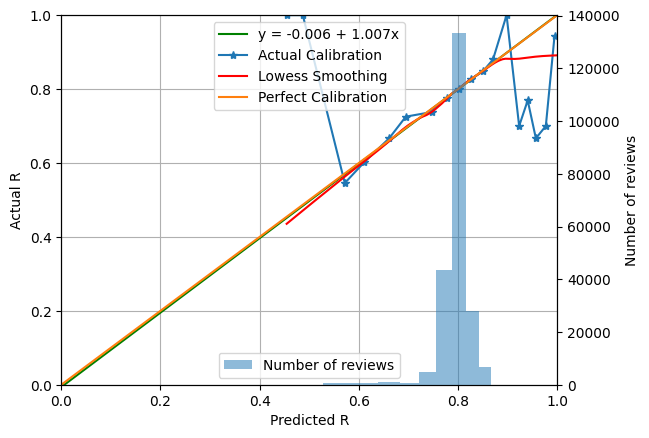

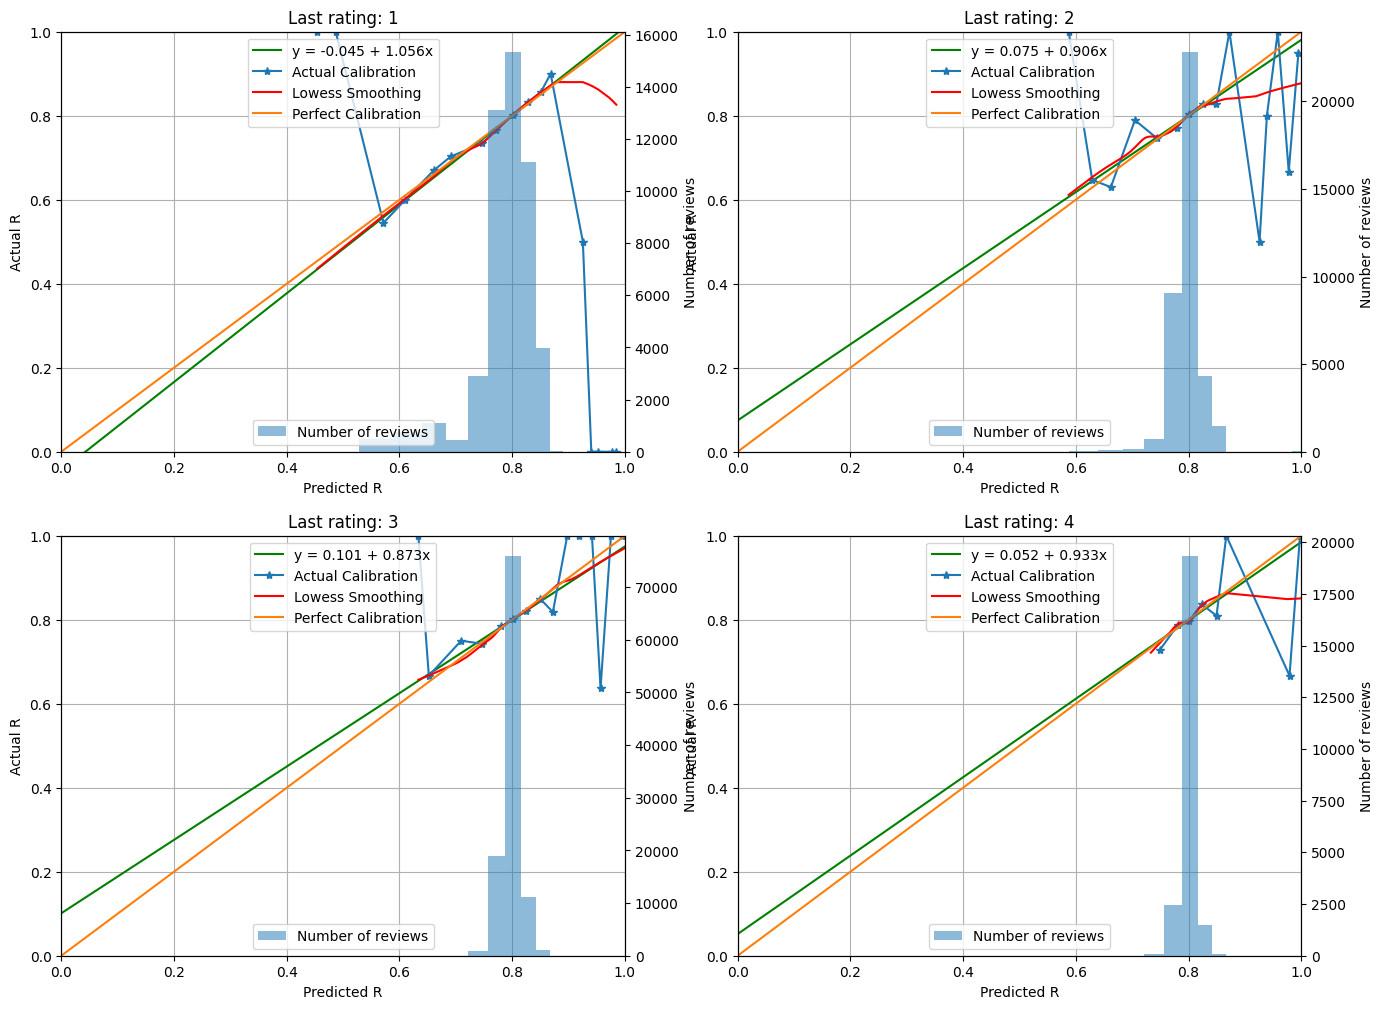

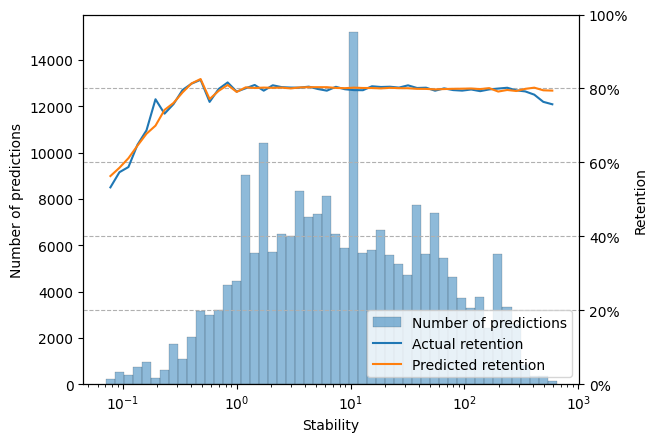

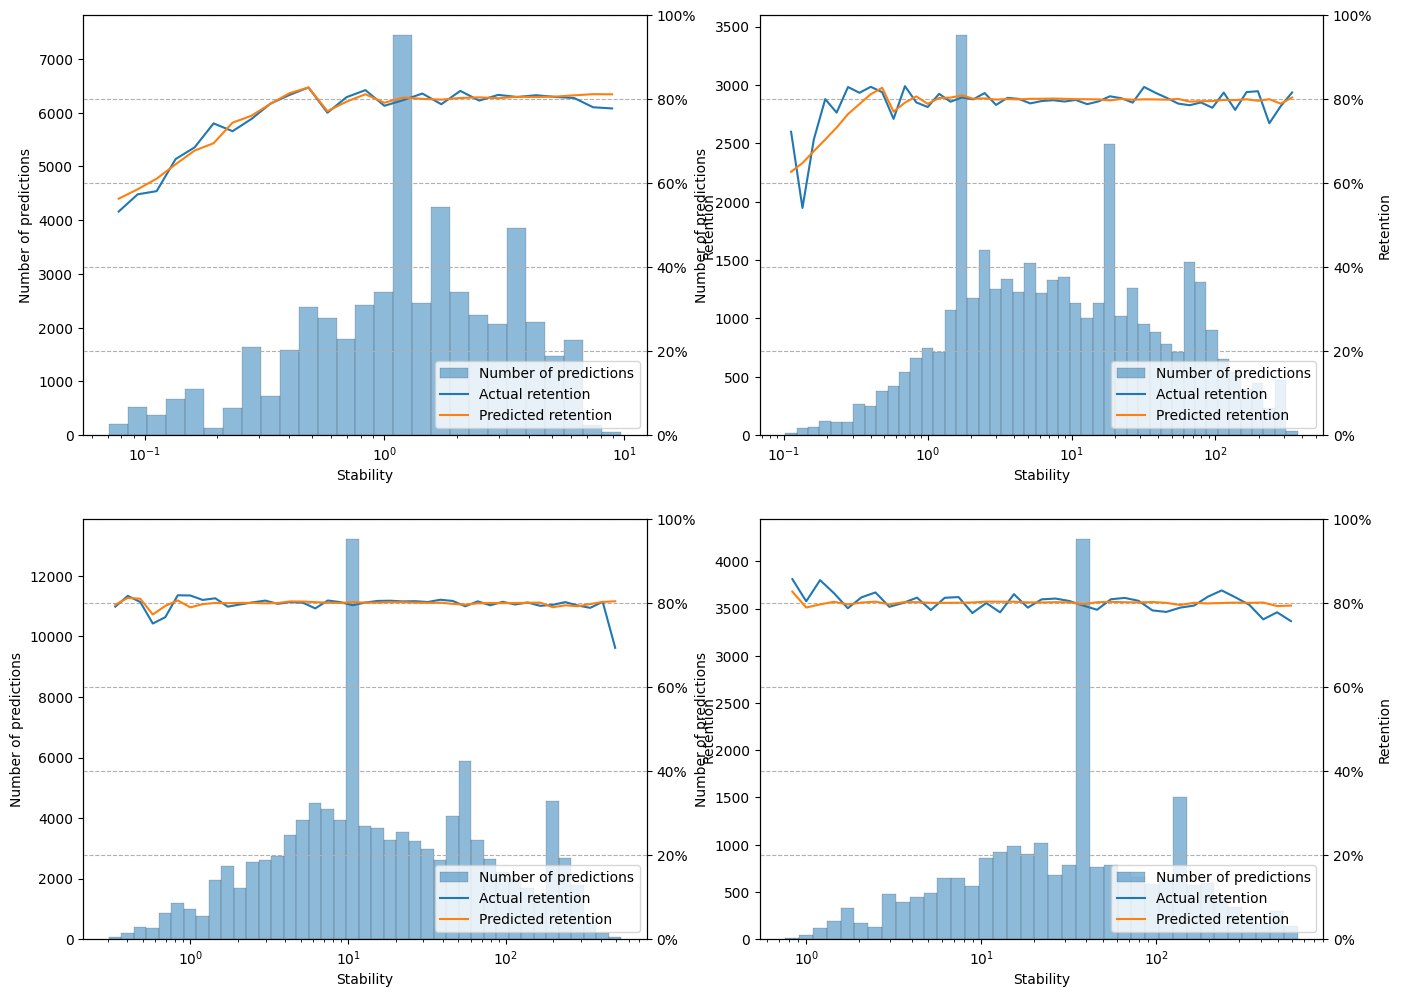

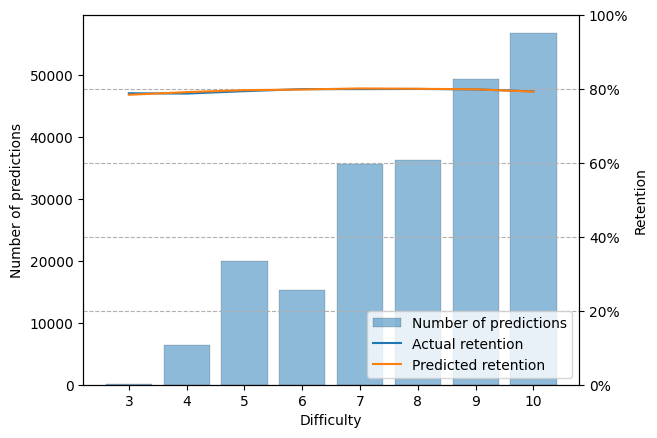

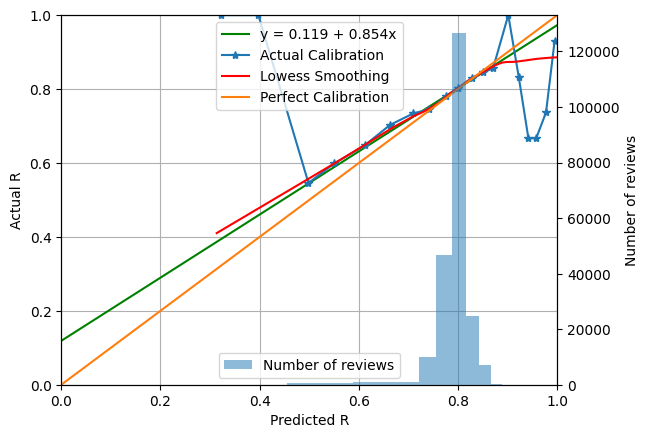

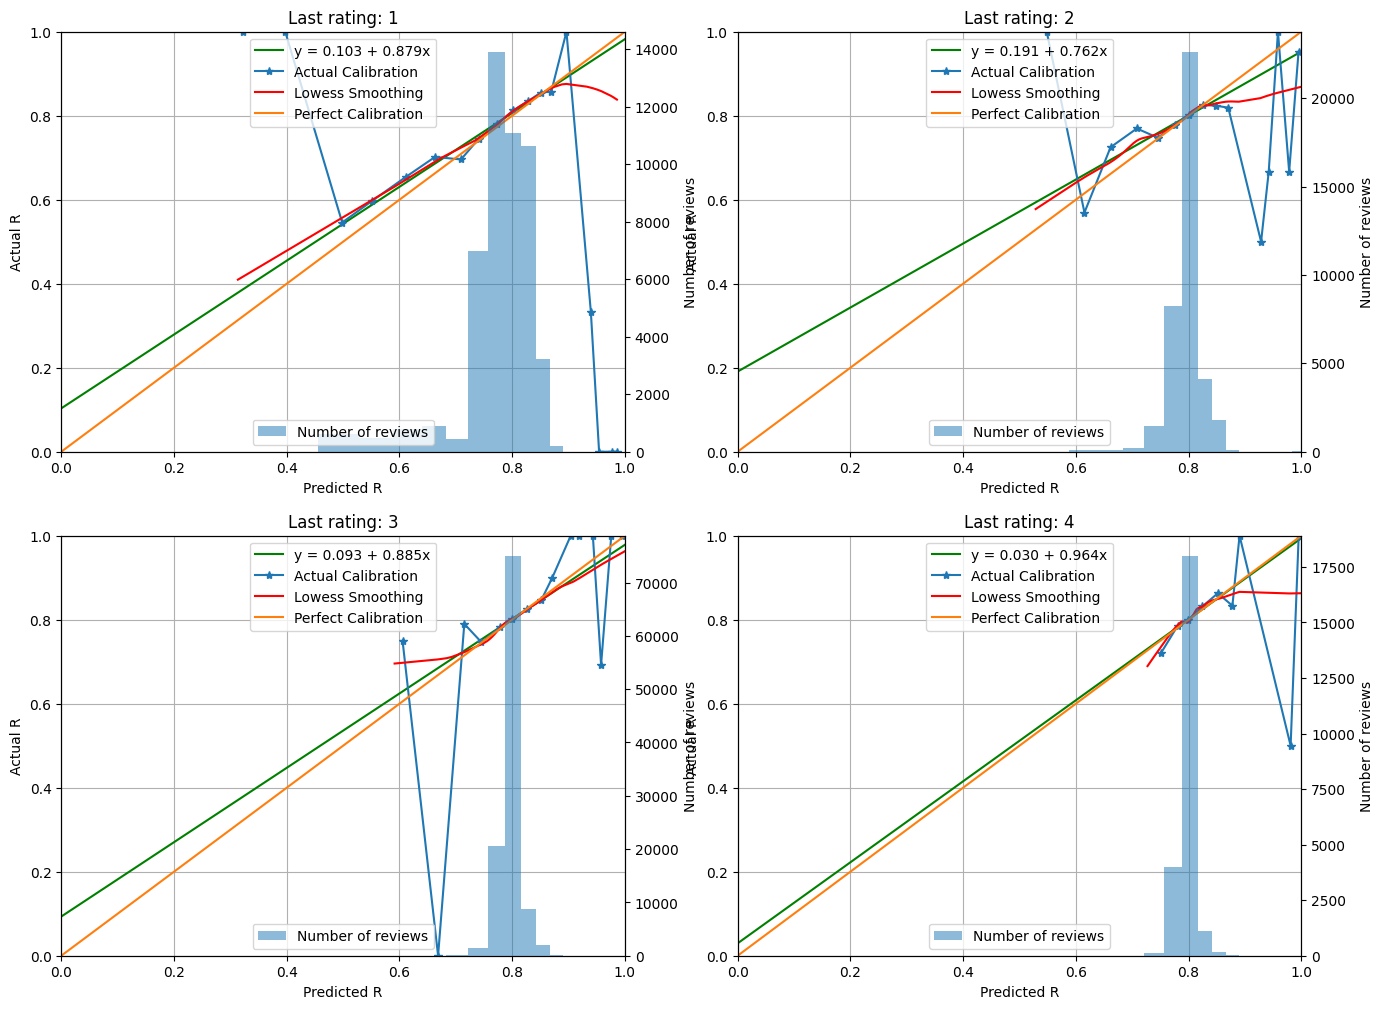

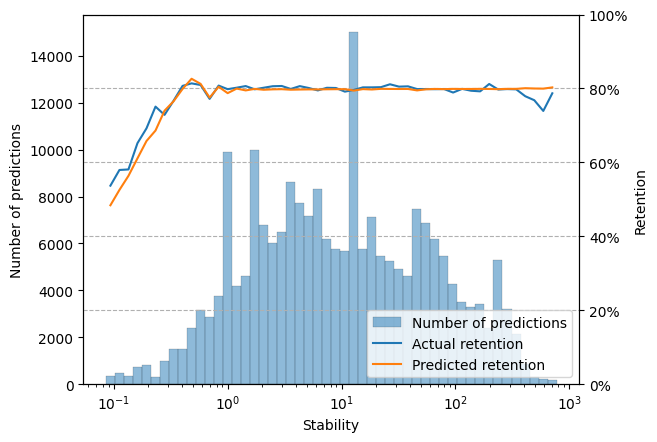

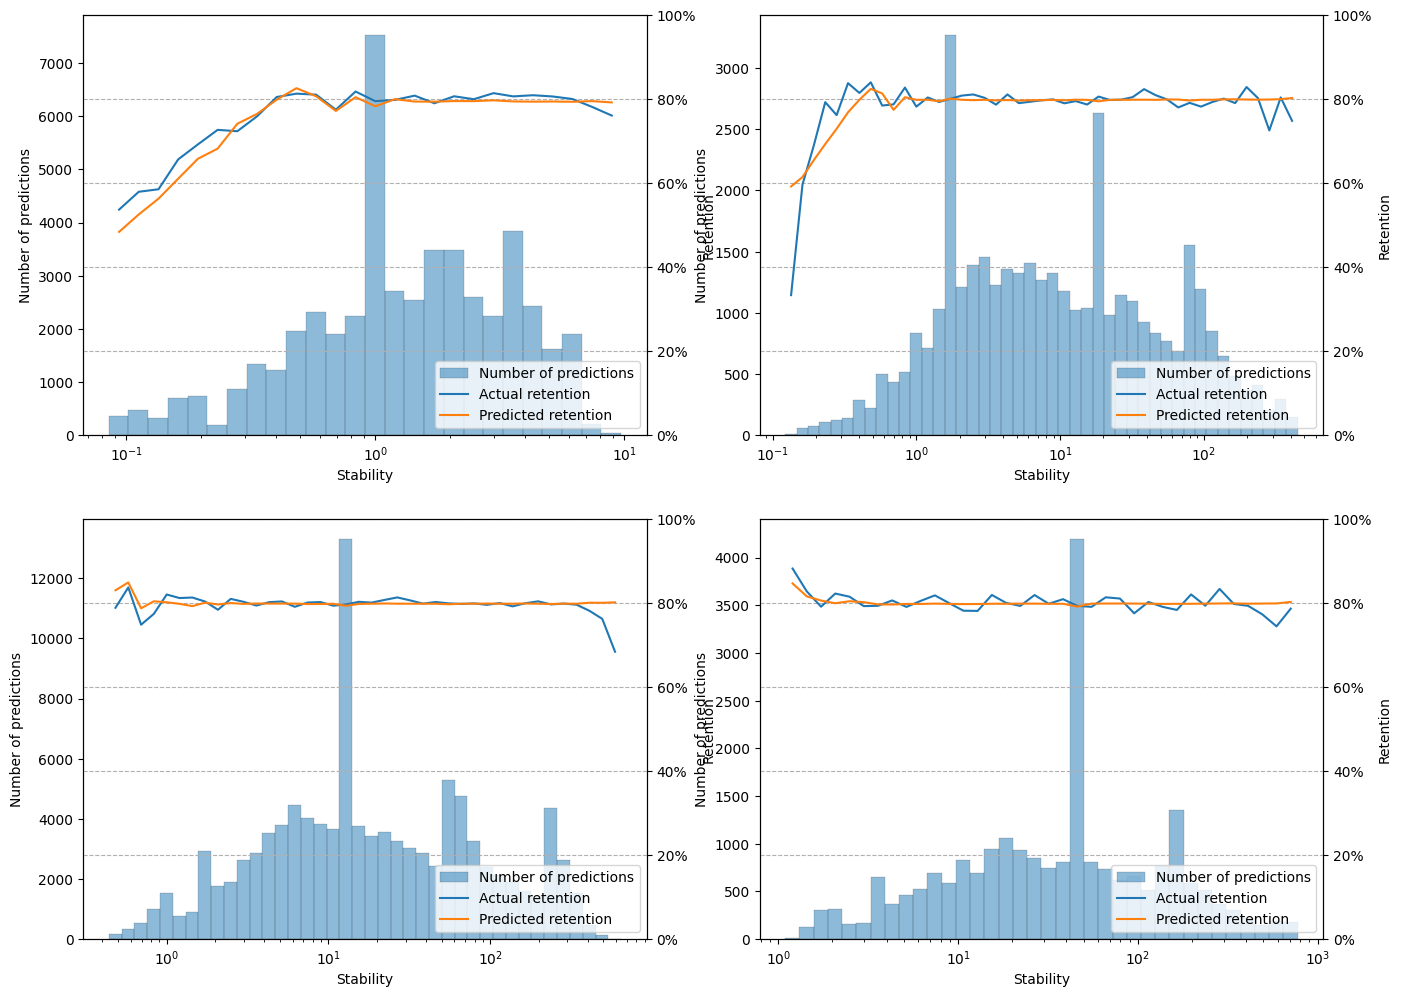

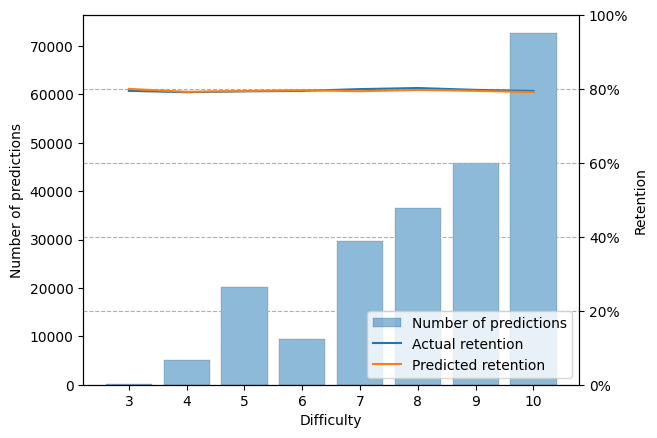

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960, 1920]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

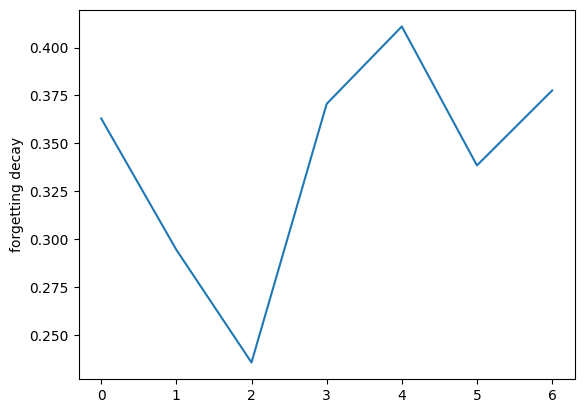

In [5]:
plt.plot(decay_list)
plt.ylabel("forgetting decay")
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}")
print(f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}")
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.001222 -0.00116  -0.001262 -0.000264 -0.000343 -0.000077 -0.000074]
RMSE(bins) (trained - ideal): [ 0.000558 -0.003561 -0.00245  -0.000014 -0.001581  0.000085 -0.000508]
AUC (trained - ideal): [ 0.006279  0.004112  0.006241  0.001446  0.001735 -0.000712  0.000008]


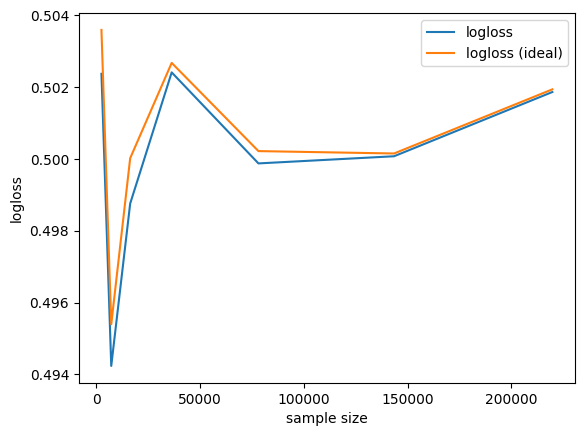

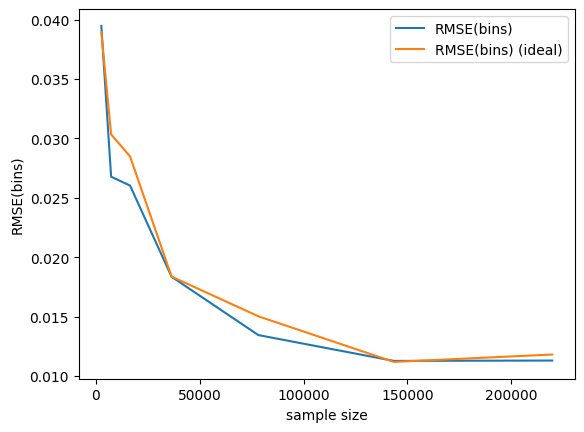

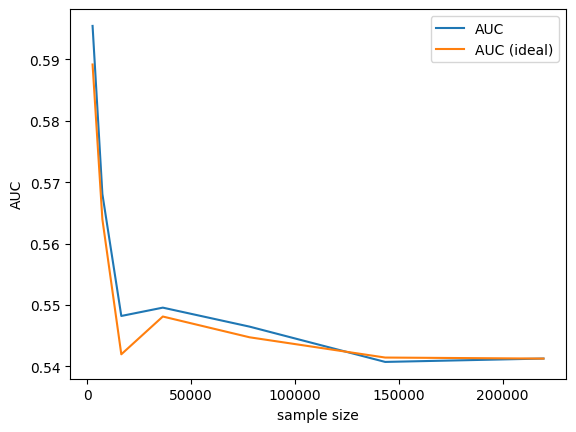

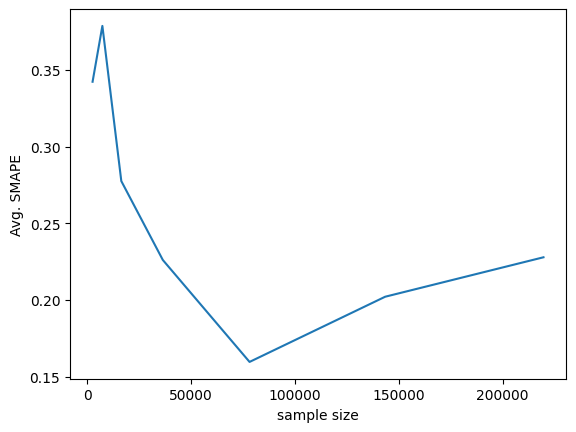

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()


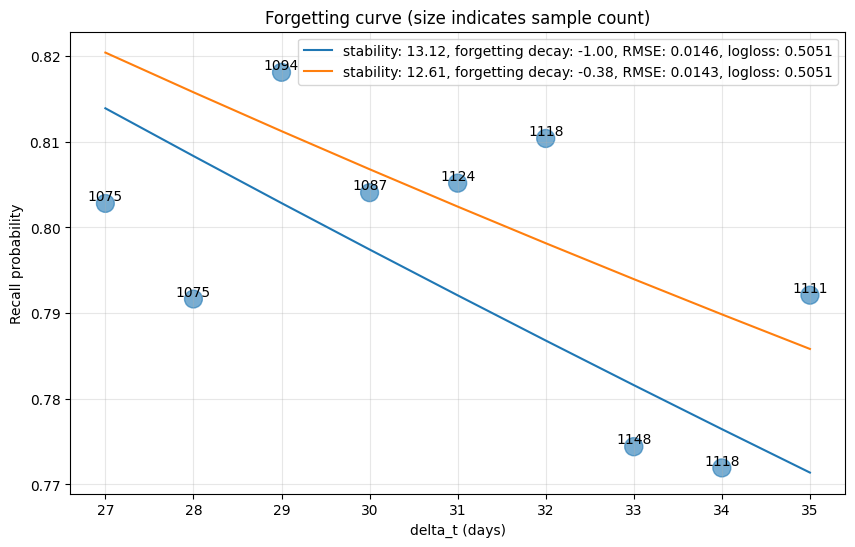

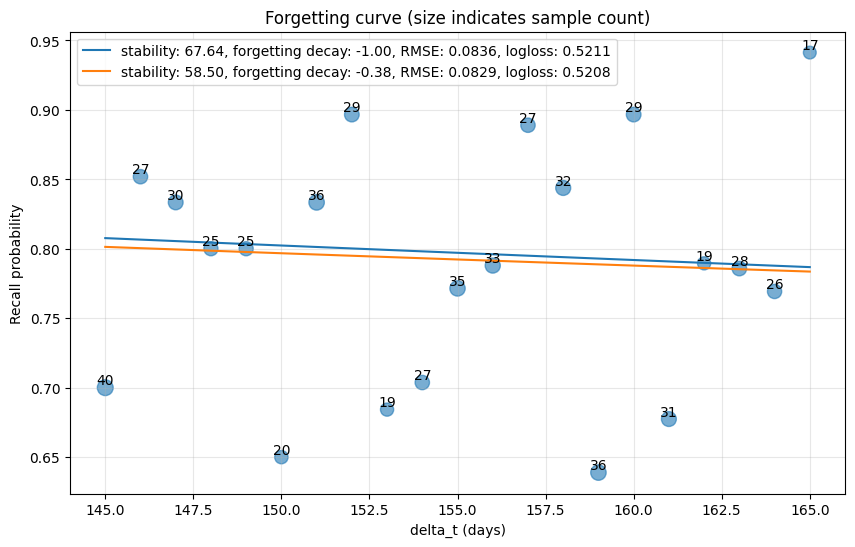

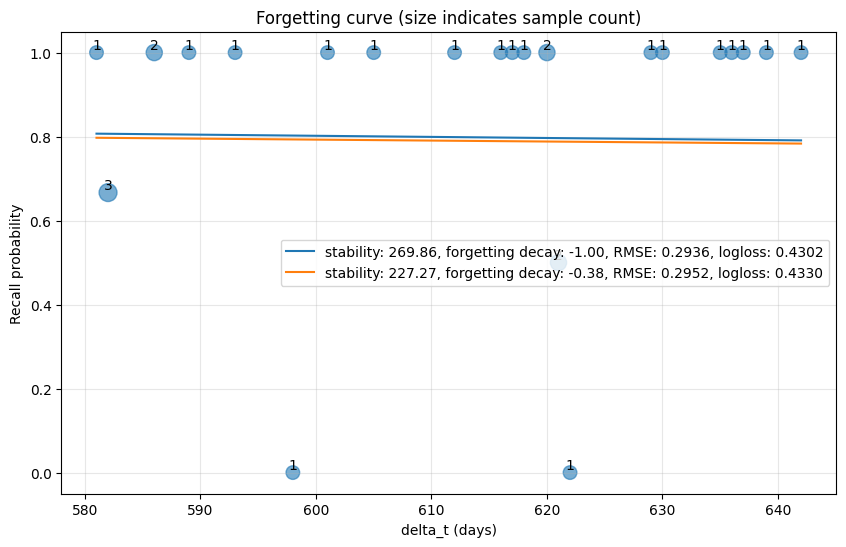

In [8]:
from fsrs_optimizer import power_forgetting_curve
from sklearn.metrics import root_mean_squared_error, log_loss

initial = Optimizer()
initial.dataset = dataset.copy()
initial.w = initial_parameters
loss_before, loss_after = initial.evaluate(save_to_file=False)
trained = Optimizer()
trained.dataset = dataset.copy()
trained.w = trained_parameters
loss_before, loss_after = trained.evaluate(save_to_file=False)
for r_history in ["3", "3,3", "3,3,3"]:
    t_history = df[df["r_history"] == r_history]["t_history"].value_counts().index[0]
    stabilities = []
    for df in [initial.dataset, trained.dataset]:
        tmp = df[(df["r_history"] == r_history) & (df["t_history"] == t_history)]
        points = tmp.groupby("delta_t")["y"].agg(["mean", "count"])
        stabilities.append(tmp["stability"].unique()[0])
    y_true = points["mean"]
    plt.figure(figsize=(10, 6))
    plt.scatter(points.index, y_true, s=np.sqrt(points["count"] / sum(points["count"])) * 500, alpha=0.6)
    for x, y in zip(points.index, y_true):
        plt.text(x, y, points["count"][x], ha='center', va='bottom')

    for s, d in zip(stabilities, [initial_parameters[19], trained_parameters[19]]):
        y_pred = power_forgetting_curve(points.index, s, -d)
        rmse = root_mean_squared_error(y_true, y_pred, sample_weight=points["count"])
        logloss = log_loss(tmp["y"], power_forgetting_curve(tmp["delta_t"], s, -d), )
        plt.plot(
            points.index,
            y_pred,
            label=f"stability: {s:.2f}, forgetting decay: {-d:.2f}, RMSE: {rmse:.4f}, logloss: {logloss:.4f}",
        )
    plt.xlabel("delta_t (days)")
    plt.ylabel("Recall probability")
    plt.title("Forgetting curve (size indicates sample count)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()